In [52]:
#whole lotta inputs ASTRO RELated
from astroquery.vizier import Vizier
import astropy.units as u

import matplotlib.pyplot as plt
from astropy.table import Table




import numpy as np

#machine learning inputs
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import pandas as pd

#machine learning inputs
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [53]:
#gaia? 
gaia = Table.read("GKTHCatalog_Table4.csv")
gaia = gaia[gaia['iso_teff'] < 9000]

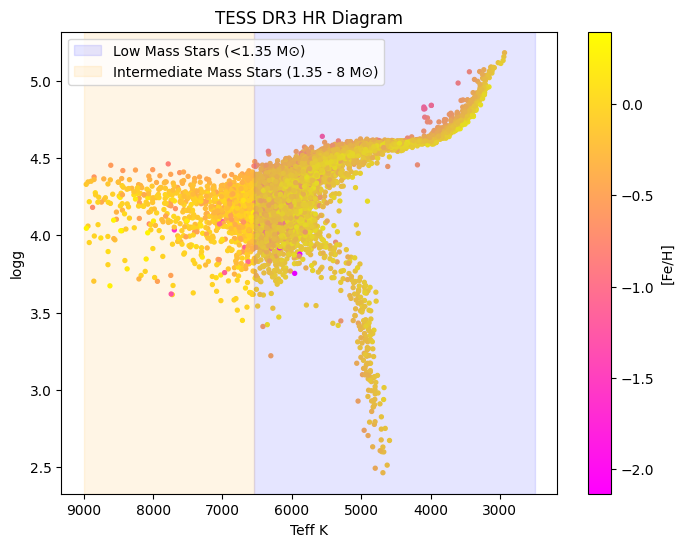

In [54]:
plt.figure(figsize=(8, 6))


sc = plt.scatter(gaia['iso_teff'], gaia['iso_logg'], c=gaia['iso_feh'], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff K')
plt.ylabel("logg")
# plt.ylim(-100,50e4)
plt.title("TESS DR3 HR Diagram")

#Hr diagram markers 
teff = gaia['iso_teff']

# Plot shaded regions for mass groups
plt.axvspan(2500, 6550, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(6550, 9000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')

# # Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('tess_hrdiagram.png')
plt.show()

In [55]:
TESS = gaia['iso_teff', 'iso_logg', 'iso_feh', 'iso_lum', 'iso_mass']

tess_df = TESS.to_pandas()
tess_df

,iso_teff,iso_logg,iso_feh,iso_lum,iso_mass
0,5610.428845,4.497660,-0.034105,0.729697,0.935053
1,5832.172919,4.352472,0.102351,1.314130,1.054473
2,5660.415369,4.475518,-0.079961,0.793808,0.935793
3,5837.403566,4.423377,0.046694,1.119828,1.033088
4,4845.001030,4.577101,0.013062,0.274921,0.755394
...,...,...,...,...,...
7901,6583.313148,4.239971,-0.032656,3.449363,1.295246
7902,7943.750417,4.251967,-0.031419,9.081913,1.641027
7903,8006.163534,4.211495,-0.137903,10.023585,1.636713
7904,8411.401871,4.138061,0.066914,17.120154,1.897798


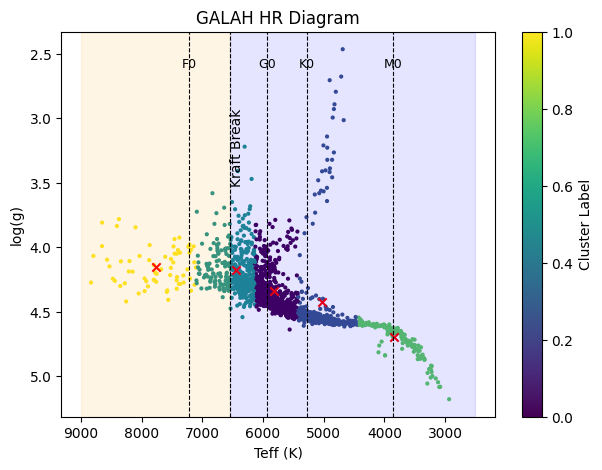

In [56]:

fitcols = [
    "iso_teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "iso_logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "iso_feh", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "iso_lum", #luminosity
    'iso_mass'
    
]
X = tess_df[fitcols]
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

#plot
plt.figure(figsize=(7, 5))
plt.scatter( X['iso_teff'].iloc[::5], X['iso_logg'].iloc[::5], c=labels[::5], s=4, cmap='viridis')
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("GALAH HR Diagram")
plt.ylabel('log(g)')
plt.xlabel('Teff (K)')
plt.gca().invert_yaxis()      # Teff increases downward
plt.gca().invert_xaxis()      # Optional, if x-axis is Teff

# Plot shaded regions for mass groups
plt.axvspan(2500, 6550, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(6550, 9000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')

spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6550, 5930, 5270, 3850]
spectral_types = ['F0', 'G0', 'K0', 'M0']
logL_values = ['0.86', '0.13', '-0.34', '-1.16']
bp_rp_values = ['0.377', '0.784', '0.983', '1.84'] 

y_top = plt.ylim()[1]

for teff, label in zip(teff_values, spectral_types_break):
    plt.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    
    if label == 'Kraft Break':
        plt.text(teff, y_top + 1.2, label, rotation=90, verticalalignment='bottom',
                 horizontalalignment='left', fontsize=10, color='black')
    else:
        plt.text(teff, y_top + 0.3, label, rotation=0, verticalalignment='bottom',
                 horizontalalignment='center', fontsize=9, color='black')

plt.colorbar(label='Cluster Label')
plt.savefig('TESS_hrdiagram_cluster5.png')

plt.show()

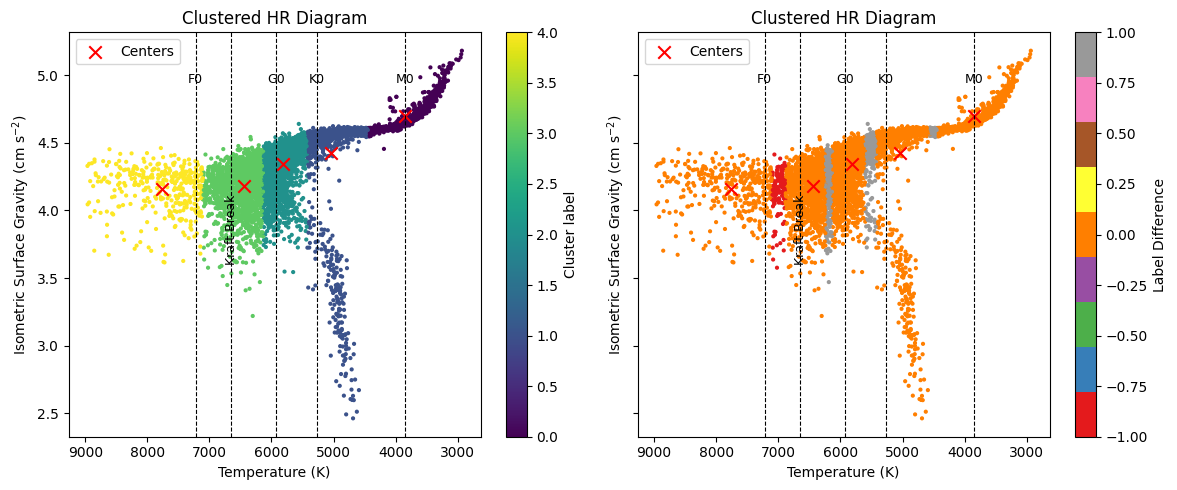

In [57]:
bin_edges = [float('inf'),  # for F0 and hotter
             (7220 + 6550)/2,
             (6550 + 5930)/2,
             (5930 + 5270)/2,
             (5270 + 3850)/2,
             float('-inf')]  # for M0 and cooler

bin_edges = bin_edges[::-1]  # smallest to largest

spectral_labels = np.arange(6)

conditions = [
    (X['iso_teff'] > bin_edges[i]) & (X['iso_teff'] <= bin_edges[i+1])
    for i in range(len(bin_edges) - 1)
]

spectral_labels = [0, 1, 2, 3, 4]

true_labels = np.select(conditions, spectral_labels)

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Sort cluster labels by Teff (column 0)
sorted_indices = np.argsort(centers[:, 0])
label_mapping = {old: new for new, old in enumerate(sorted_indices)}
labels = np.vectorize(label_mapping.get)(labels)

# Downsample for plotting
x_plot = X['iso_teff']
y_plot = X['iso_logg']

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Scatter plots
points = axs[0].scatter(x_plot, y_plot, c=labels, s=4)
misclassified = labels - true_labels
points_misclass = axs[1].scatter(x_plot, y_plot, c=misclassified, s=4, cmap='Set1')

# Plot spectral lines and labels
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6650, 5930, 5270, 3850]

for ax in axs:
    y_top = ax.get_ylim()[1]
    for teff, label in zip(teff_values, spectral_types_break):
        ax.axvline(teff, color='black', linestyle='--', linewidth=0.8)
        y_offset = 0.3 if label != 'Kraft Break' else 1.2
        ax.text(teff, y_top - y_offset, label,
                rotation=90 if label == 'Kraft Break' else 0,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=9)
        
    ax.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=80, label='Centers')
    ax.set_title("Clustered HR Diagram")
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'Isometric Surface Gravity (cm s$^{-2}$)')
    ax.invert_xaxis()
    ax.legend()

# Add colorbars
fig.colorbar(points, ax=axs[0], label='Cluster label')
fig.colorbar(points_misclass, ax=axs[1], label='Label Difference')

plt.tight_layout()
plt.show()


ConfusionMatrix [[ 797   97    0    0    0]
 [   0 1715  538    0    0]
 [   0    0 2422  467    0]
 [   0    0    0 1374    0]
 [   0    0    0  129  367]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       894
           1       0.95      0.76      0.84      2253
           2       0.82      0.84      0.83      2889
           3       0.70      1.00      0.82      1374
           4       1.00      0.74      0.85       496

    accuracy                           0.84      7906
   macro avg       0.89      0.85      0.86      7906
weighted avg       0.87      0.84      0.85      7906



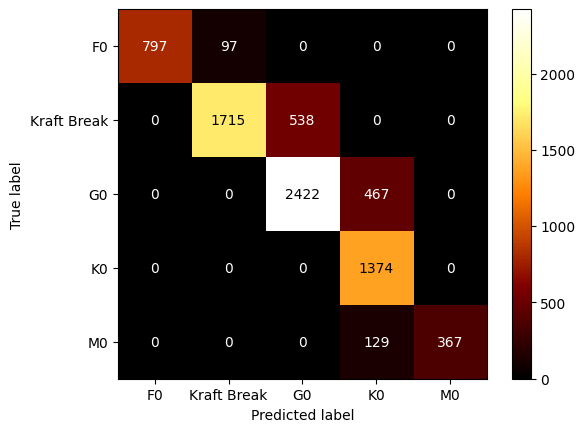

In [58]:
spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
#teff_values = [7220, 6650, 5930, 5270, 3850]
cm = confusion_matrix(true_labels,labels)
print("ConfusionMatrix",cm)
print(classification_report(true_labels,labels))

disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

In [59]:
bounds = [[min(X['iso_teff'].to_numpy()[np.where(labels==spec_class)]), max(X['iso_teff'].to_numpy()[np.where(labels==spec_class)])] for spec_class in spectral_labels]
print(bounds)

[[np.float64(2933.57538892298), np.float64(4437.001598509317)], [np.float64(4440.292909683966), np.float64(5426.402568554604)], [np.float64(5426.719060956579), np.float64(6132.558493236047)], [np.float64(6132.90925980249), np.float64(7102.809698709217)], [np.float64(7104.834259369561), np.float64(8963.787281621873)]]


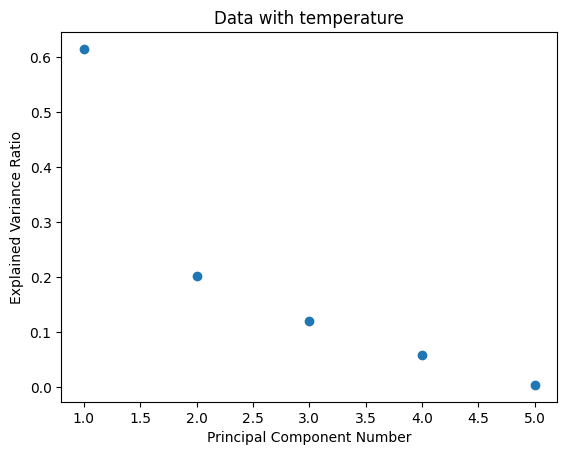

In [60]:
df_norm = (X - X.mean()) / X.std()
ncomp=len(fitcols)
pcaT = PCA(n_components=ncomp)
x_transform = pcaT.fit_transform(df_norm)
explained_variances = pcaT.explained_variance_ratio_
plt.scatter(np.arange(1,ncomp+1), explained_variances)
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Data with temperature')
plt.show()

In [61]:
loadings = pd.DataFrame(pcaT.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(fitcols))],
                        index=X.columns)
loadings

,PC1,PC2,PC3,PC4,PC5
iso_teff,0.485375,-0.107575,0.651934,0.071164,-0.568116
iso_logg,-0.485868,-0.078018,0.425987,0.737339,0.180865
iso_feh,-0.070871,0.982968,0.090397,0.038949,-0.138066
iso_lum,0.471838,0.036763,-0.550901,0.670378,-0.152048
iso_mass,0.548352,0.121502,0.286100,0.018526,0.776113


In [62]:
reg_df = tess_df.copy()
reg_df['label'] = true_labels

Xclf = reg_df[fitcols]
yclf= reg_df['label']

X_train, X_test, y_train, y_test = train_test_split(Xclf, yclf, test_size=0.4, random_state=42)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, criterion='log_loss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

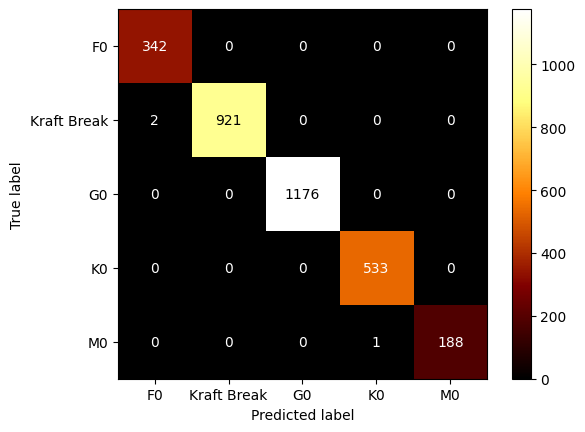

/tmp/ipykernel_31134/975901657.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


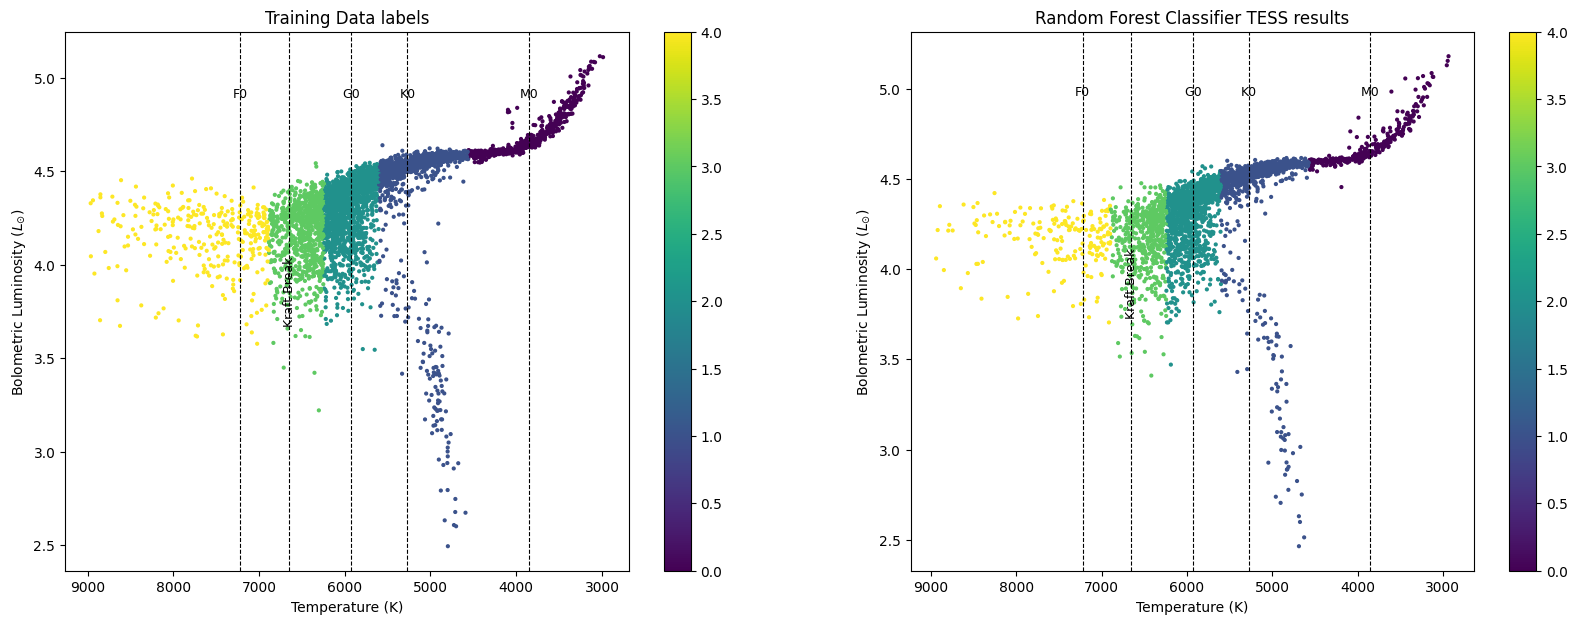

In [63]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = spectral_types_break)
disp.plot(cmap='afmhot')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(20,7))
points = ax[1].scatter(X_test['iso_teff'], X_test['iso_logg'], c=y_pred, s=4)
ax[0].scatter(X_train['iso_teff'], X_train['iso_logg'], c=y_train, s=4)
ax[1].set_title("Random Forest Classifier TESS results")
ax[0].set_title("Training Data labels")

for a in ax:
    a.set_xlabel('Temperature (K)')
    a.set_ylabel(r'Bolometric Luminosity ($L_{\odot}$)')
    a.invert_xaxis()
    y_top = a.get_ylim()[1]
    for teff, label in zip(teff_values, spectral_types_break):
        a.axvline(teff, color='black', linestyle='--', linewidth=0.8)
        y_offset = 0.3 if label != 'Kraft Break' else 1.2
        a.text(teff, y_top - y_offset, label,
                rotation=90 if label == 'Kraft Break' else 0,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=9)
    fig.colorbar(points, ax=a)

fig.show()

In [64]:
boundsRFC = [[min(tess_df['iso_teff'].to_numpy()[np.where(y_pred==spec_class)]), max(tess_df['iso_teff'].to_numpy()[np.where(y_pred==spec_class)])] for spec_class in spectral_labels]
boundsRFC

[[np.float64(3537.30445559111), np.float64(8448.355022269147)],
 [np.float64(3386.594774632668), np.float64(8937.124881578278)],
 [np.float64(3118.333122689403), np.float64(8850.319277400602)],
 [np.float64(3707.2563891061504), np.float64(8963.787281621873)],
 [np.float64(3499.9396391560786), np.float64(7397.58976681748)]]